In [1]:
from models import *
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np 

epochs = 64

ma = lambda x,N : np.convolve(x, np.ones(N)/N, mode='valid')

def open_dataset_file(filename):
    with gzip.open(filename, 'rb') as f:
        return pickle.load(f)


In [2]:
data08 = open_dataset_file('./data/cavity/h_202210.pickle.gzip')
data10 = open_dataset_file('./data/cavity/h_202210.pickle.gzip')
data = data08+data10
# subsampling 4 more times
data = [d[[0,2,4],::8,:] for d in data]

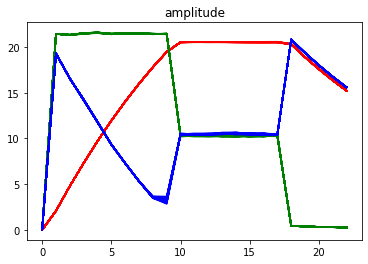

In [3]:
plt.plot(data[0][0,:,:],'r')
plt.plot(data[0][1,:,:],'g')
plt.plot(data[0][2,:,:],'b')
plt.title('amplitude')
plt.show()

selecting 30 as anomalies (they are healthly!), 306 remains


Text(0.5, 1.0, 'nullify')

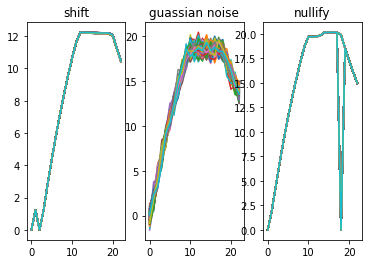

In [4]:
data_faulty = data[-30:]
data_healthly = data[:-30]
print(f'selecting {len(data_faulty)} as anomalies (they are healthly!), {len(data_healthly)} remains')

def shift(d, shift = 2):
    ''' shift signal'''
    d[:,shift:,:] = d[:,:-shift,:]
    return d

def add_noise(d,noise = 0.5, since = 50):
    ''' adds gaussian noise '''
    return d[:,:,since:] + noise * np.random.randn(*d[...,since:].shape)

def nullify(d,N = 1, since = 50):
    idx = np.random.randint(0,d.shape[1], N)
    d[:,idx,since:] = 0.0
    return d

data_faulty[:10] = [shift(d) for d in data_faulty[:10]]
data_faulty[10:20] = [add_noise(d) for d in data_faulty[10:20]]
data_faulty[20:] = [nullify(d) for d in data_faulty[20:]]

plt.subplot(131)
plt.plot(data_faulty[0][0,:,:])
plt.title('shift')
plt.subplot(132)
plt.plot(data_faulty[15][0,:,:])
plt.title('guassian noise')
plt.subplot(133)
plt.plot(data_faulty[20][0,:,:])
plt.title('nullify')

  0%|          | 0/64 [00:00<?, ?it/s]

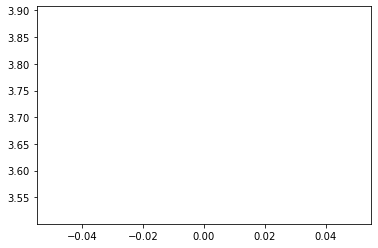

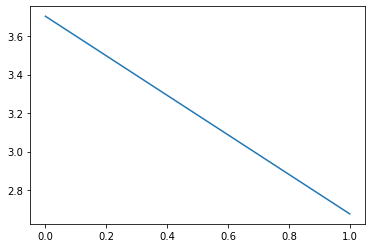

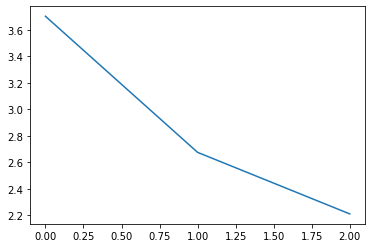

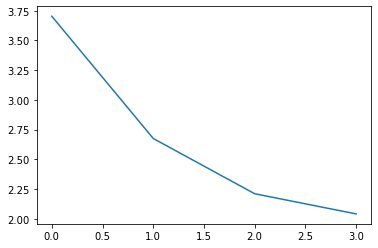

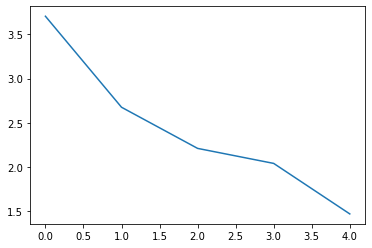

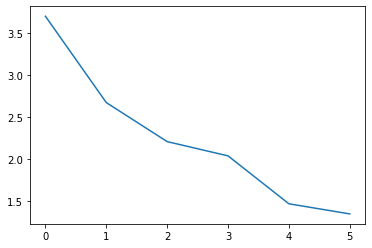

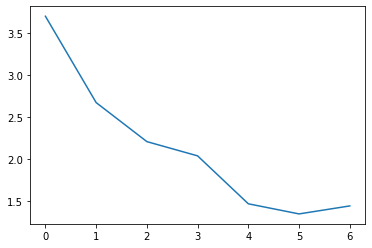

In [ ]:
class RNNCavityAnomalyDetector(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(RNNCavityAnomalyDetector, self).__init__()
        self.rnn = nn.GRU(input_dim, embedding_dim, batch_first = True)
        self.linear = nn.Linear(embedding_dim, embedding_dim)
        self.c = nn.Parameter(torch.randn(embedding_dim),requires_grad = False)
    def phi(self, x):
        '''
        This function is the encoder which embeds inputs 
        '''
        # rnn returns two tuples, first is output, the second are hidden states
        return self.linear(self.rnn(x)[0])
    
    def forward(self, x):
        phi = self.phi(x)
        return torch.linalg.vector_norm(phi - self.c, dim = -1)
input_dim = 3 * 23 
# the original shape is (6,23,signal length), it must be restructured to 
# fit to the GRU structure, i.e. (1,signal lenght, 6 * 23)
data = [torch.tensor(d.reshape((1,input_dim,-1)).transpose(0,2,1)).float() for d in data_healthly + data_faulty]
data = [((d / d.max()) - 0.5) * 2 for d in data]

# 1 for ok data, -1 for the created faults 
labels = torch.cat((torch.ones((len(data_healthly))),-torch.ones((len(data_faulty)))))

model = RNNCavityAnomalyDetector(input_dim, 16)
optimizer = optim.Adam(model.parameters(), lr = 0.1)
losses = []

for epoch in tqdm(range(epochs)):
    y = [model(d) ** labels[i] for i, d in enumerate(data[:])]
    # optimisation 
    loss = torch.cat(y,-1).flatten().mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    plt.plot(losses)
    plt.show()